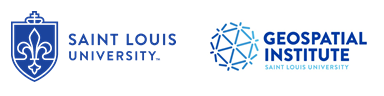

# Lab 03: Tour of Scikit-learn Algorithms Part 2
## GIS 5092: Applied Machine Learning for GIS and Remote Sensing (Fall 2021)
Course Instructor: **Dr. Vasit Sagan** (vasit.sagan@slu.edu)
Teaching Assistant: **Sourav Bhadra** (sourav.bhadra@slu.edu)  
[Join Slack Workspace for this class](https://join.slack.com/t/gis5092-fall21/shared_invite/zt-u9vpmzat-SB5sYNtaPWk3vW_Qbj8QRQ)

## Learning Objectives:

* Prepare training and testing dataset for classification
* Train classifiers using scikit-learn
* Apply a trained classifier to an image

# How to work with this Notebook?
Write your answers in places where you see **YOUR ANSWER HERE** within the **#### ... ####** comments. If there is a variable already declared and assigned a value of **None**, then just replace your code with the assigned **None**. If your answer is code, then use the Code cell, if its text, then use the Text cell. Save a copy of this notebook in your Lab Folder by replacing the STUDENT with your SURNAME in CAPS. Then Upload your deliverables (items listed at the end of this document) in Canvas.

---

# Classification with a larger sample size

In Part 2, you will perform a LULC task for the same image and study area, but the training sample now has a much larger sample size. You will find the ground truth label shapefile named as <code>lulc_labels_large.shp</code> in <code>lab3</code> folder. Use the same image (<code>LC08_L2SP_024033_20201016_20201105_02_T1_SR_Composite.tif</code>) you used before to extract reflectance information. Apply your best trained model to the <code>LC08_L2SP_024033_20201016_20201105_02_T1_SR_Composite_Small.tif</code> and visualize it as a map. Follow the key tasks:

1. Read image and shapefile
2. Consider the fact that there might be nodata in the image
3. Extract pixel value from each point
4. Remember to convert your data from 0 to 1
5. Encode your label data, i.e., text label to integer codes
6. Shuffle your data and split your data into train and test set
7. Train a **Random Forest** and **Support Vector Machine** classifier for the training set. Play around with the hyperparameters so that you get better accuracy in the test set
8. Apply the best performing model to the smaller image
9. Save the LULC map as a raster data in <code>lab3</code> folder as <code>LULC2.tif</code>
10. Create a map of LULC2.tif in ArcGIS Desktop or ArcGIS Pro 

**Notes:**
* Instead of 5 classes, you have to deal with 8 classes in <code>lulc_labels_large.shp</code>. The labels are: 'Agriculture', 'Barren', 'Developed', 'Forest', 'Herbaceous', 'Shrub', 'Water', 'Wetland'. So when you are encoding the texts into integer, be careful not to just copy paste from Part 1. Change codes wherever necessary.

In [1]:
import os
print(os.getcwd())

D:\Assignment3_Barth\lab3


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
import geopandas as gpd

In [3]:
src = rasterio.open('data/LC08_L2SP_024033_20201016_20201105_02_T1_SR_Composite.tif')

In [4]:
img = src.read()

In [5]:
img = img.astype(float) 
img[img == 0] = np.nan

In [6]:
def band_stat(band, band_name):

    ### YOUR ANSWER HERE ###

    # Get max, min, mean
    max_val = np.nanmax(band)
    min_val = np.nanmin(band)
    mean_val = np.nanmean(band)

    ########################

    print(f"{band_name}, Max: {max_val:.2f}, Min: {min_val:.2f}, Mean: {mean_val:.2f}")

band_stat(img[0, :, :], 'B1')
band_stat(img[1, :, :], 'B2')
band_stat(img[2, :, :], 'B3')
band_stat(img[3, :, :], 'B4')
band_stat(img[4, :, :], 'B5')
band_stat(img[5, :, :], 'B6')
band_stat(img[6, :, :], 'B7')

B1, Max: 51440.00, Min: 1.00, Mean: 8581.66
B2, Max: 45222.00, Min: 8.00, Mean: 8896.45
B3, Max: 34714.00, Min: 8.00, Mean: 9801.00
B4, Max: 36618.00, Min: 34.00, Mean: 10341.96
B5, Max: 45539.00, Min: 5469.00, Mean: 15948.55
B6, Max: 65454.00, Min: 6515.00, Mean: 15937.85
B7, Max: 65454.00, Min: 6800.00, Mean: 12717.42


In [7]:
img = img/65536

In [8]:
points = gpd.read_file('data/lulc_labels_large.shp')
points

,UID,Label,geometry
0,0,Wetland,POINT (693714.174 4347476.783)
1,1,Agriculture,POINT (765867.104 4306413.218)
2,2,Agriculture,POINT (639486.185 4254365.344)
3,3,Forest,POINT (585087.231 4242592.508)
4,4,Developed,POINT (718363.803 4275233.381)
...,...,...,...
9995,9995,Forest,POINT (678262.408 4247215.022)
9996,9996,Agriculture,POINT (749399.748 4252238.676)
9997,9997,Developed,POINT (609949.843 4259599.361)
9998,9998,Forest,POINT (595608.875 4284576.990)


In [9]:
def extract_pixel_value_from_point(point_shape, image_src, image_np):
    
    """
    Extracts the pixel value(s) from a given point shapefile and
    a numpy geospatial image.
    
    Arguments:
        - point_shape: A geopandas dataframe containing the point
            feature. It must have a UID specified which indicates
            an unique ID.
        - image_src: A rasterio source. The reference system of
            both shapefile and image has to match with each other.
        - image_np: A np.ndarray version of the rasterio image.
            The array should be free from nodata values.
    
    Returns:
        - values_df: A pandas dataframe containing the UID and
            associated pixel value(s).
    """
    
    # Empty dictionary to hold all the pixel values
    values_dict = {}
    
    # Loop through each point feature and populate the dict
    for i, point in enumerate(point_shape['geometry']):
        
        # Get the x and y coordinate
        x = point.xy[0][0]
        y = point.xy[1][0]
        
        # Get the associated row col number
        # based on the coordinate
        row, col = image_src.index(x, y)
        values = image_np[:, row, col]
        
        # Get the UID
        uid = point_shape.iloc[i, 0]
        
        # Populate the dictionary
        values_dict[uid] = values
        
    # Convert the dictionary to a pd dataframe
    values_df = pd.DataFrame(values_dict).T
    # Reset the index of the df
    values_df.reset_index(inplace=True)
    # Change the column names
    values_df.columns = ['UID', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']
    
    return values_df

# Apply the function
reflectance = extract_pixel_value_from_point(points, src, img)
reflectance

,UID,B1,B2,B3,B4,B5,B6,B7
0,0,0.125961,0.127792,0.136520,0.137772,0.217850,0.225113,0.174469
1,1,0.132614,0.138641,0.153397,0.165268,0.223846,0.243256,0.196930
2,2,0.125565,0.128250,0.146759,0.138428,0.323959,0.229446,0.170441
3,3,0.124298,0.124817,0.130844,0.130173,0.203064,0.193726,0.154190
4,4,0.137817,0.140686,0.158325,0.163681,0.226227,0.225159,0.196945
...,...,...,...,...,...,...,...,...
9995,9995,0.125427,0.129456,0.142105,0.144455,0.271851,0.244293,0.178925
9996,9996,0.138763,0.148941,0.172592,0.200729,0.273270,0.327164,0.260834
9997,9997,0.126923,0.128891,0.142456,0.146484,0.231308,0.225922,0.177643
9998,9998,0.122360,0.124130,0.133728,0.132111,0.219360,0.205429,0.164108


In [10]:
data = reflectance.join(points, on='UID', rsuffix='_')
data

,UID,B1,B2,B3,B4,B5,B6,B7,UID_,Label,geometry
0,0,0.125961,0.127792,0.136520,0.137772,0.217850,0.225113,0.174469,0,Wetland,POINT (693714.174 4347476.783)
1,1,0.132614,0.138641,0.153397,0.165268,0.223846,0.243256,0.196930,1,Agriculture,POINT (765867.104 4306413.218)
2,2,0.125565,0.128250,0.146759,0.138428,0.323959,0.229446,0.170441,2,Agriculture,POINT (639486.185 4254365.344)
3,3,0.124298,0.124817,0.130844,0.130173,0.203064,0.193726,0.154190,3,Forest,POINT (585087.231 4242592.508)
4,4,0.137817,0.140686,0.158325,0.163681,0.226227,0.225159,0.196945,4,Developed,POINT (718363.803 4275233.381)
...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,0.125427,0.129456,0.142105,0.144455,0.271851,0.244293,0.178925,9995,Forest,POINT (678262.408 4247215.022)
9996,9996,0.138763,0.148941,0.172592,0.200729,0.273270,0.327164,0.260834,9996,Agriculture,POINT (749399.748 4252238.676)
9997,9997,0.126923,0.128891,0.142456,0.146484,0.231308,0.225922,0.177643,9997,Developed,POINT (609949.843 4259599.361)
9998,9998,0.122360,0.124130,0.133728,0.132111,0.219360,0.205429,0.164108,9998,Forest,POINT (595608.875 4284576.990)


In [11]:
from sklearn.utils import shuffle
data = shuffle(data)

data = data[['Label', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']]
data

,Label,B1,B2,B3,B4,B5,B6,B7
4248,Forest,0.120499,0.122635,0.131119,0.135574,0.212921,0.211365,0.165588
5598,Agriculture,0.148315,0.161972,0.190521,0.225204,0.301147,0.337494,0.269440
5710,Forest,0.123062,0.125076,0.135254,0.138306,0.212402,0.211288,0.168808
1265,Agriculture,0.135101,0.140320,0.152420,0.168564,0.217865,0.275726,0.231705
108,Wetland,0.119614,0.121384,0.133286,0.128189,0.257980,0.200348,0.152191
...,...,...,...,...,...,...,...,...
2725,Agriculture,0.149384,0.159744,0.182037,0.209610,0.285156,0.318893,0.252731
9904,Agriculture,0.128006,0.131042,0.143051,0.147308,0.243240,0.251831,0.190002
8153,Water,0.123032,0.128052,0.140564,0.140106,0.122940,0.118713,0.116516
9199,Agriculture,0.143494,0.151245,0.163284,0.168777,0.269485,0.259827,0.212158


In [12]:
data['Label_int'] = 0


for i in range(data.shape[0]):
    label_txt = data.iloc[i, 0]
    
    if label_txt=='Water':
        data.iloc[i, -1] = 1
    elif label_txt=='Wetland':
        data.iloc[i, -1] = 2
    elif label_txt=='Developed':
        data.iloc[i, -1] = 3
    elif label_txt=='Forest':
        data.iloc[i, -1] = 4
    elif label_txt=='Agriculture':
        data.iloc[i, -1] = 5
    elif label_txt=='Barren':
        data.iloc[i, -1] = 6
    elif label_txt=='Herbaceous':
        data.iloc[i, -1] = 7
    elif label_txt=='Shrub':
        data.iloc[i, -1] = 8
        
data

,Label,B1,B2,B3,B4,B5,B6,B7,Label_int
4248,Forest,0.120499,0.122635,0.131119,0.135574,0.212921,0.211365,0.165588,4
5598,Agriculture,0.148315,0.161972,0.190521,0.225204,0.301147,0.337494,0.269440,5
5710,Forest,0.123062,0.125076,0.135254,0.138306,0.212402,0.211288,0.168808,4
1265,Agriculture,0.135101,0.140320,0.152420,0.168564,0.217865,0.275726,0.231705,5
108,Wetland,0.119614,0.121384,0.133286,0.128189,0.257980,0.200348,0.152191,2
...,...,...,...,...,...,...,...,...,...
2725,Agriculture,0.149384,0.159744,0.182037,0.209610,0.285156,0.318893,0.252731,5
9904,Agriculture,0.128006,0.131042,0.143051,0.147308,0.243240,0.251831,0.190002,5
8153,Water,0.123032,0.128052,0.140564,0.140106,0.122940,0.118713,0.116516,1
9199,Agriculture,0.143494,0.151245,0.163284,0.168777,0.269485,0.259827,0.212158,5


In [13]:
train_size = int(data.shape[0] * 0.7) 

X_train = data.iloc[:train_size, 1:-1]
y_train = data.iloc[:train_size, -1]
X_test = data.iloc[train_size:, 1:-1]
y_test = data.iloc[train_size:, -1]

In [14]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(7000, 7)
(7000,)
(3000, 7)
(3000,)


In [15]:
# Import the random forest classifier from sklearn
from sklearn.ensemble import RandomForestClassifier

# Import the support vector machine classifier from sklearn
from sklearn.svm import SVC

In [16]:
rfc = RandomForestClassifier().fit(X_train, y_train)
print("Train set 1: " + str(rfc.score(X_train, y_train)))
print("Test set 1: " + str(rfc.score(X_test, y_test)))

rfc2 = RandomForestClassifier(n_estimators = 1000, criterion='entropy', random_state=0).fit(X_train, y_train)
print("Train set 2: " + str(rfc2.score(X_train, y_train)))
print("Test set 2: " + str(rfc2.score(X_test, y_test)))

Train set 1: 1.0
Test set 1: 0.807
Train set 2: 1.0
Test set 2: 0.809


In [17]:
svc = SVC().fit(X_train, y_train)
print("Train set 1: " + str(svc.score(X_train, y_train)))
print("Test set 1: " + str(svc.score(X_test, y_test)))

svc2 = SVC(kernel ='linear', gamma = 'auto').fit(X_train, y_train)
print("Train set 2: " + str(svc2.score(X_train, y_train)))
print("Test set 2: " + str(svc2.score(X_test, y_test)))

Train set 1: 0.7994285714285714
Test set 1: 0.8103333333333333
Train set 2: 0.7442857142857143
Test set 2: 0.7546666666666667


In [18]:
src_small = rasterio.open('.\data\LC08_L2SP_024033_20201016_20201105_02_T1_SR_Composite_Small.tif')
img_small = src_small.read()

img_small = img_small / 65536

print(img_small.shape)

(7, 501, 501)


In [19]:
img_channel_last = np.moveaxis(img_small, 0, 2)

print(img_channel_last.shape)

img_reshaped = img_channel_last.reshape(-1, 7)

print(img_reshaped.shape)

(501, 501, 7)
(251001, 7)


In [20]:
lulc_1d = rfc2.predict(img_reshaped)

print(lulc_1d.shape)

(251001,)


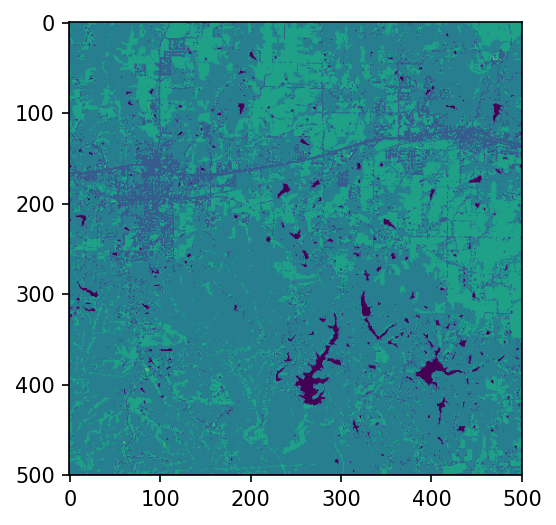

In [21]:
lulc_2d = lulc_1d.reshape(img_small.shape[1], img_small.shape[2])

plt.figure(dpi=150)
plt.imshow(lulc_2d)
plt.show()

In [22]:
profile = src_small.profile
profile.update({'count': 1})
with rasterio.open('.\data\LULC2.tif', 'w', **profile) as dst:
    dst.write(lulc_2d.astype(rasterio.uint16), 1)

---

# Deliverables from Part 2

* The completed notebook named <code>a3_tour_of_scikitlearn_algorithms_Part2_STUDENT.ipynb</code> (change the STUDENT with your surname or SLU net id)
* A Microsoft Word Document (.docx) file where you have a table with different models, hyperparameters and test scores (The template of the table is given in **Part 1 Task 10**)
* A JPG map of LULC2.tif created in ArcGIS Desktop or ArcGIS Pro (or any geospatial software of your liking), where you provide map title, legends, north arrow, scale bar etc.